### Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

#### Installing & Importing Libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
import glob

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


### Importing Train and Test data directories

In [3]:
# defining paths for train and test directories
data_dir_train = pathlib.Path("/content/drive/MyDrive/Upgrad/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/drive/MyDrive/Upgrad/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [4]:
train_images=len(list(data_dir_train.glob('*/*.jpg')))    ## off_disk train images
test_images=len(list(data_dir_test.glob('*/*.jpg')))      ## off_disk test images

In [18]:
# Let's create train and validation dataset by loading images from training directory

batch_size = 32
img_height = 180
img_width = 180

# Creating the training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory  (
    data_dir_train,
    validation_split=0.2,  # 20% of the data will be used for validation
    subset="training",     # Specify that this is the training subset
    seed=123,              # Set the random seed for reproducibility
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Creating the validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,  # 20% of the data will be used for validation
    subset="validation",   # Specify that this is the validation subset
    seed=123,              # Set the random seed for reproducibility
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [6]:
## store all the class_names in variable
class_names=train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize our dataset with each categorical image

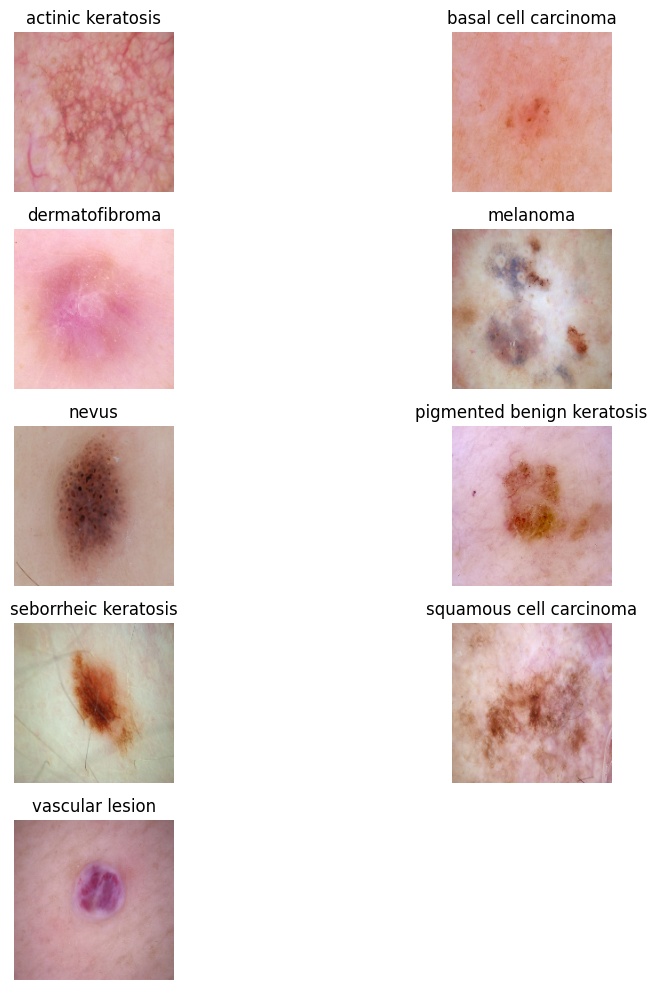

In [7]:
# Create a figure and subplots with a layout depending on the number of classes
num_classes = len(class_names)
rows = (num_classes + 1) // 2  # Calculate the number of rows for subplots

plt.figure(figsize=(10, 10))

# Iterate through each class and visualize a few images
for i in range(num_classes):
    plt.subplot(rows, 2, i + 1)

    # Find the first image of the current class
    for images, labels in train_ds:
        class_indices = tf.where(labels == i)[:, 0]
        if class_indices.shape[0] > 0:
            image_index = class_indices[0]
            plt.imshow(images[image_index].numpy().astype("uint8"))
            plt.title(class_names[i])
            plt.axis("off")
            break  # Display only one image per class

plt.tight_layout()
plt.show()

In [8]:
## Dataset.cache() keep the images in memory after they're loaded off disk during the first epoch.

## Dataset.prefetch() overlaps data preprocessing and model execution while training.

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create basic CNN Model:

In [9]:
# Define total number of categorical classes
num_classes = len(class_names)

# Create a sequential model with pixel rescaling between [0,1], convolutional layers, MaxPooling layers and fully connected layers

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])

# Compile the model

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

# Print a summary of the model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train Model

In [10]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20,
  verbose=1
)

Epoch 1/20
56/56 [==============================] - 635s 3s/step - loss: 1.9360 - accuracy: 0.2790 - val_loss: 1.7358 - val_accuracy: 0.3669
Epoch 2/20
56/56 [==============================] - 1s 23ms/step - loss: 1.7061 - accuracy: 0.3722 - val_loss: 1.6926 - val_accuracy: 0.3803
Epoch 3/20
56/56 [==============================] - 1s 23ms/step - loss: 1.6314 - accuracy: 0.4079 - val_loss: 1.6116 - val_accuracy: 0.4318
Epoch 4/20
56/56 [==============================] - 1s 23ms/step - loss: 1.5015 - accuracy: 0.4593 - val_loss: 1.5638 - val_accuracy: 0.4251
Epoch 5/20
56/56 [==============================] - 1s 23ms/step - loss: 1.4561 - accuracy: 0.4777 - val_loss: 1.4200 - val_accuracy: 0.5213
Epoch 6/20
56/56 [==============================] - 1s 23ms/step - loss: 1.3745 - accuracy: 0.5140 - val_loss: 1.4520 - val_accuracy: 0.5235
Epoch 7/20
56/56 [==============================] - 1s 24ms/step - loss: 1.3147 - accuracy: 0.5329 - val_loss: 1.3831 - val_accuracy: 0.5324
Epoch 8/20
56

### Visualizing Training results

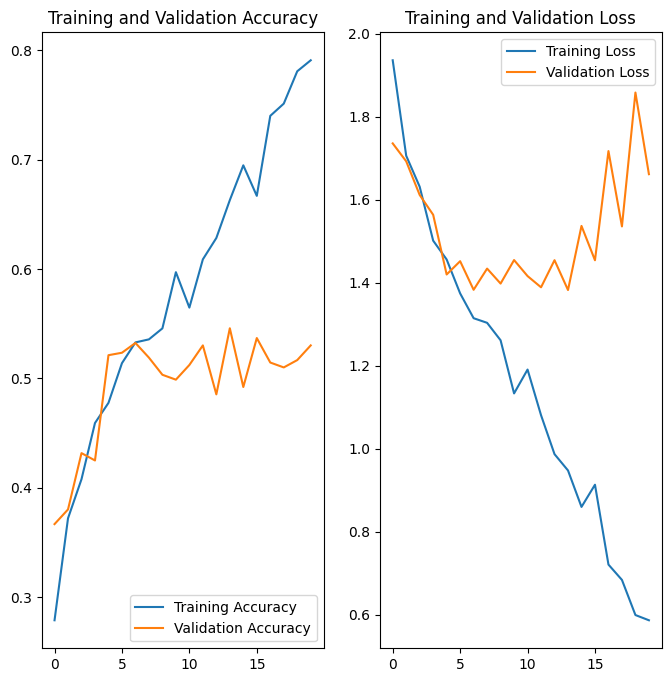

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

From above plot, we can conclude that our CNN model is heavily over-fitting as training accuracy reached near to 84% while validation accuracy reached only 53%.<br>
We will try Data augmentation technique to get rid from this overfitting.

### Data Augmentation of training images

First, we will apply data augmentation pipeline for particular image only, and we will see all augmented versions of it

In [12]:
# Create data augmentation object using sequential

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.RandomFlip("vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2)
  ]
)

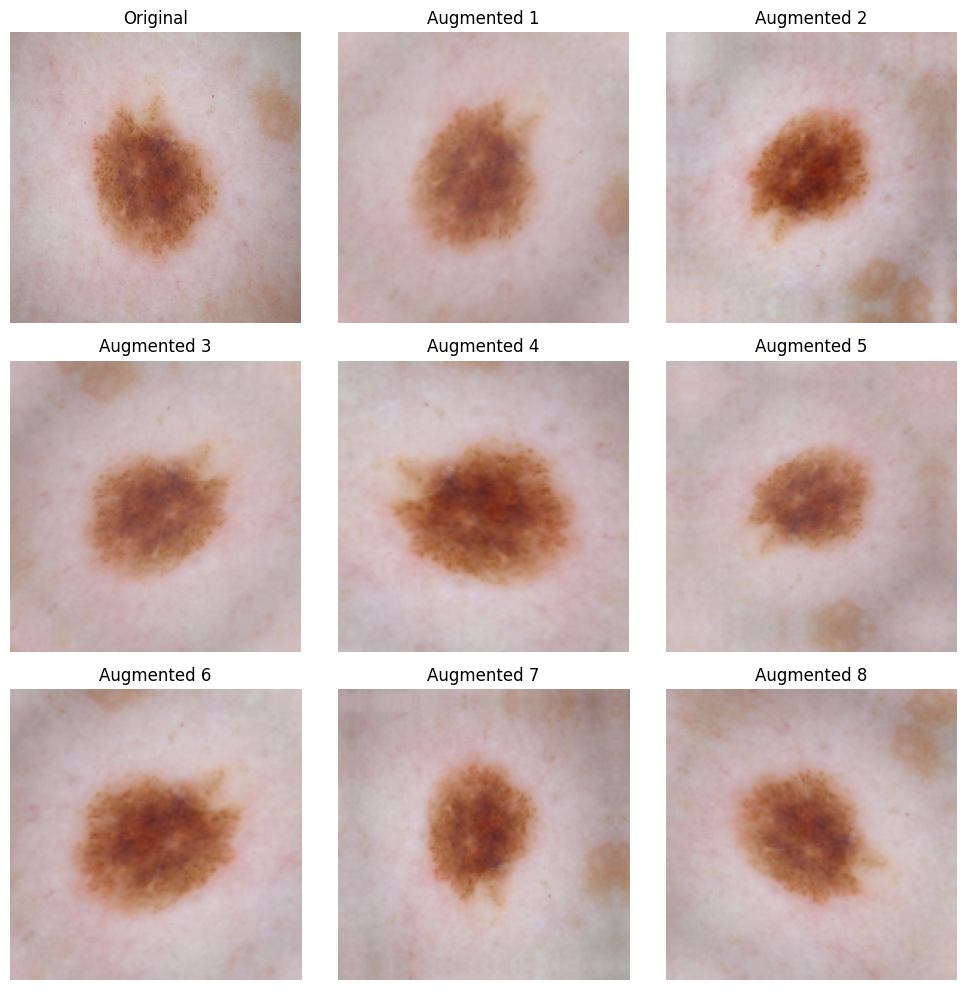

In [13]:
# Visualize the original and augmented images using data augmentation

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  # plot original image
  plt.subplot(3, 3, 1)
  plt.imshow(images[0].numpy().astype("uint8"))
  plt.title("Original")
  plt.axis('off')
  for i in range(8):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 2)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.title("Augmented {}".format(i + 1))
    plt.axis("off")

plt.tight_layout()
plt.show()

In [14]:
# Now, we will define new CNN architecture just by adding data_augmentation and dropout layers to our previous CNN model

# Define total number of categorical classes
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(9,activation='softmax')
])

# Compile the model

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

# Print a summary of the model architecture
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [15]:
#Train a model

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20,
  verbose=1
)

Epoch 1/20
56/56 [==============================] - 6s 37ms/step - loss: 2.0131 - accuracy: 0.2584 - val_loss: 1.8344 - val_accuracy: 0.3557
Epoch 2/20
56/56 [==============================] - 2s 34ms/step - loss: 1.7284 - accuracy: 0.3627 - val_loss: 1.6269 - val_accuracy: 0.4340
Epoch 3/20
56/56 [==============================] - 2s 33ms/step - loss: 1.5478 - accuracy: 0.4448 - val_loss: 1.5333 - val_accuracy: 0.4497
Epoch 4/20
56/56 [==============================] - 2s 33ms/step - loss: 1.5280 - accuracy: 0.4665 - val_loss: 1.5897 - val_accuracy: 0.4631
Epoch 5/20
56/56 [==============================] - 2s 34ms/step - loss: 1.4036 - accuracy: 0.5095 - val_loss: 1.4110 - val_accuracy: 0.5190
Epoch 6/20
56/56 [==============================] - 2s 35ms/step - loss: 1.3858 - accuracy: 0.5156 - val_loss: 1.3934 - val_accuracy: 0.5302
Epoch 7/20
56/56 [==============================] - 2s 34ms/step - loss: 1.3467 - accuracy: 0.5223 - val_loss: 1.3738 - val_accuracy: 0.5213
Epoch 8/20
56

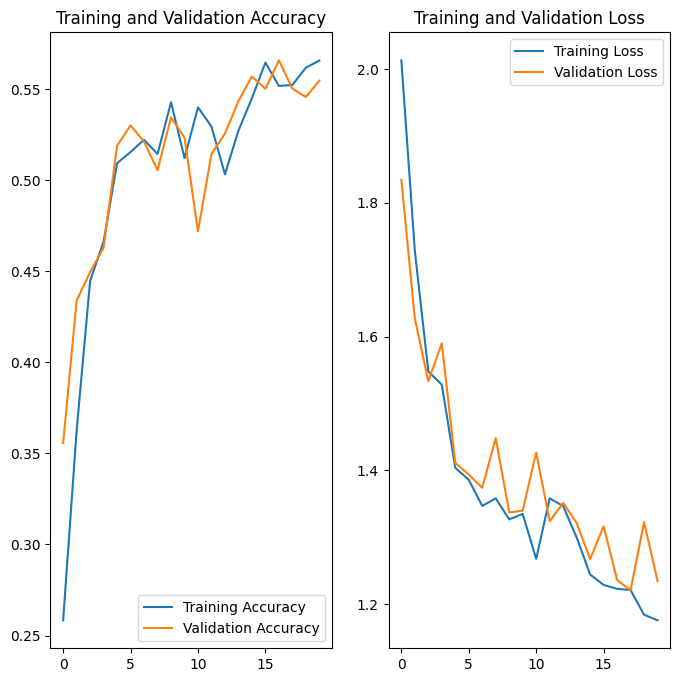

In [16]:
# Visualizing Training and Validation accuracy

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

From, above plot we can conclude that our over-fitting issue has been resolved to a great extent. But model's training accuracy is very less.

### Find the distribution of classes in training dataset

In [20]:
# Get class names from the dataset
class_names = train_ds.class_names
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [21]:
# Initialize a dictionary to store class counts
class_counts = {class_name: 0 for class_name in class_names}

# Iterate through the train_ds and count occurrences of each class
for images, labels in train_ds:
    for label in labels:
        class_name = class_names[label]
        class_counts[class_name] += 1

In [22]:
for class_name,count in class_counts.items():
  print(f"{class_name}:{count}")

actinic keratosis:92
basal cell carcinoma:309
dermatofibroma:77
melanoma:352
nevus:277
pigmented benign keratosis:370
seborrheic keratosis:58
squamous cell carcinoma:142
vascular lesion:115


From above class distribution, we found that basal cell carcinoma, melanoma, nevus and pigmented benign keratosis class have majority part in train_ds.<br>
So to reduce this heavy class imbalance we will use augmentor library.

In [23]:
# Augmentor will add more samples across all classes so that none of the classes have very few samples

!pip install -q Augmentor

In [24]:
import Augmentor

In [25]:
path_to_training_dataset="/content/drive/MyDrive/Upgrad/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset +"/"+ i)
    p.rotate(probability=0.4, max_left_rotation=10, max_right_rotation=10)
    p.flip_left_right(probability=0.4)
    p.flip_top_bottom(probability=0.4)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Upgrad/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F4F00DD5240>: 100%|██████████| 500/500 [00:15<00:00, 32.12 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Upgrad/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F4F00195A50>: 100%|██████████| 500/500 [00:16<00:00, 30.01 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Upgrad/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F4F002C0BE0>: 100%|██████████| 500/500 [00:19<00:00, 26.21 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Upgrad/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F4F00FF2170>: 100%|██████████| 500/500 [01:00<00:00,  8.27 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Upgrad/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=853x680 at 0x7F4F011C31F0>: 100%|██████████| 500/500 [00:47<00:00, 10.60 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Upgrad/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F4F055CA5F0>: 100%|██████████| 500/500 [00:16<00:00, 29.41 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Upgrad/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F4F00194D00>: 100%|██████████| 500/500 [00:29<00:00, 16.81 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Upgrad/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F4F011C4B50>: 100%|██████████| 500/500 [00:13<00:00, 36.94 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Upgrad/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F4F00184850>: 100%|██████████| 500/500 [00:14<00:00, 34.32 Samples/s]


In [26]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [27]:
## Let's create new train_ds and val_ds with augmented and original images

## Please note that our data_dir_train will remain same as it will contain original as well as augmented images
train_ds = tf.keras.preprocessing.image_dataset_from_directory  (
    data_dir_train,
    validation_split=0.2,  # 20% of the data will be used for validation
    subset="training",     # Specify that this is the training subset
    seed=123,              # Set the random seed for reproducibility
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Creating the validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,  # 20% of the data will be used for validation
    subset="validation",   # Specify that this is the validation subset
    seed=123,              # Set the random seed for reproducibility
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.
Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [28]:
# Now, let's check the again data distribution of each class

# Initialize a dictionary to store class counts
class_counts = {class_name: 0 for class_name in class_names}

# Iterate through the train_ds and count occurrences of each class
for images, labels in train_ds:
    for label in labels:
        class_name = class_names[label]
        class_counts[class_name] += 1

for class_name,count in class_counts.items():
  print(f"{class_name}:{count}")

actinic keratosis:493
basal cell carcinoma:721
dermatofibroma:455
melanoma:755
nevus:677
pigmented benign keratosis:773
seborrheic keratosis:456
squamous cell carcinoma:569
vascular lesion:493


Now, we can easily see that our image class distribution is somewhat balanced compared to without augmentation.

In [32]:
# Create a CNN model:  (we will use original images with augmented images by augmentor)

# Define total number of categorical classes
num_classes = len(class_names)

# Create a sequential model with pixel rescaling between [0,1], convolutional layers, MaxPooling layers and fully connected layers with data_augmentation and dropout

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])

# Compile the model

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

# Print a summary of the model architecture
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                 

In [33]:
# Train a model
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=30,
  verbose=1
)

Epoch 1/30
169/169 [==============================] - 44s 236ms/step - loss: 1.9333 - accuracy: 0.2602 - val_loss: 1.6060 - val_accuracy: 0.3957
Epoch 2/30
169/169 [==============================] - 43s 250ms/step - loss: 1.5698 - accuracy: 0.3859 - val_loss: 1.4335 - val_accuracy: 0.4425
Epoch 3/30
169/169 [==============================] - 39s 222ms/step - loss: 1.4804 - accuracy: 0.4173 - val_loss: 1.4313 - val_accuracy: 0.4343
Epoch 4/30
169/169 [==============================] - 39s 223ms/step - loss: 1.4313 - accuracy: 0.4390 - val_loss: 1.4847 - val_accuracy: 0.4380
Epoch 5/30
169/169 [==============================] - 37s 212ms/step - loss: 1.3969 - accuracy: 0.4579 - val_loss: 1.2694 - val_accuracy: 0.5048
Epoch 6/30
169/169 [==============================] - 44s 255ms/step - loss: 1.3508 - accuracy: 0.4655 - val_loss: 1.3650 - val_accuracy: 0.4878
Epoch 7/30
169/169 [==============================] - 37s 215ms/step - loss: 1.3368 - accuracy: 0.4785 - val_loss: 1.3534 - val_ac

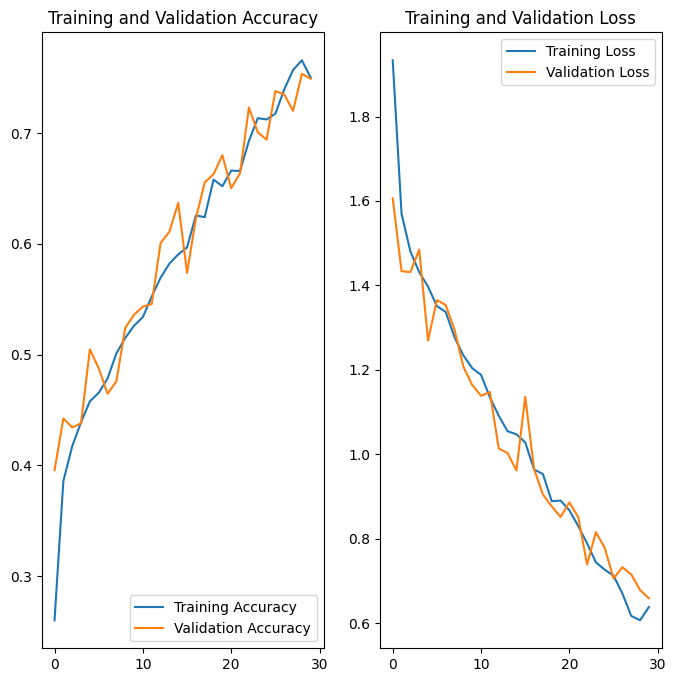

In [35]:
# Visualize model results

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(30)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

From above accuracy plots, we conclude that, training with augmented images using Augmentor is highly desirable as it is giving very good accuracy on training and validation both datasets with maintaining class balance.<br>

To avoid chances of overfitting, we have to add data_augmentation and dropout in CNN model architecture.